## Human Activity Recognition Berdasarkan Tangkapan Webcam Menggunakan Metode MobileNet

### Import Library

In [1]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
%load_ext autotime

time: 0 ns (started: 2022-06-21 10:08:32 +07:00)


### Set Hyperparamaters

In [2]:
FPS = 25
EPOCHS = 20
INIT_LR = 1e-4
BATCH_SIZE = 16
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224
N_SPLIT = 5
CLASSES_DICT = {0:'No Cheat', 1:'Read Text', 2:'Ask Friend', 5:'Call Friend'}
CLASSES_LIST = ['No Cheat', 'Read Text', 'Ask Friend', 'Call Friend']
MODEL_OUTPUT_SIZE = len(CLASSES_LIST)
BASE_DIR = '../../..'

time: 0 ns (started: 2022-06-21 10:08:43 +07:00)


### Parse Label from Ground Truth (gt.txt) to Label (subject{SUBJECT}_label.csv)

In [ ]:
import pandas as pd

SUBJECT = 1
MAX_ROWS = 864

f = open(f'../../../../OEP database/subject{SUBJECT}/gt.txt', 'r')

list_of_lists = []
for line in f:
  stripped_line = line.strip()
  line_list = stripped_line.split()
  list_of_lists.append(line_list)

def get_sec(time_str):
  """Get Seconds from time."""
  minute = int(time_str[0:2])
  second = int(time_str[2:4])
  return (minute*60) + second

converted_list = []
for row in list_of_lists:
  temp = []
  for item in row:
    if len(item) == 4:
      temp.append(get_sec(item))
    else:
      temp.append(item)
  converted_list.append(temp)

max_rows = MAX_ROWS
data = pd.DataFrame({
  'id': [x for x in range(max_rows+1)],
  'frame': [f'subject{SUBJECT}_frame{x}.jpg' for x in range(max_rows+1)],
  'label': ['0' for x in range(max_rows+1)]})

for gt in converted_list:
  data.loc[(data.id >= gt[0]) & (data.id <= gt[1]), 'label'] = gt[2]

data.to_csv(f'{BASE_DIR}/HAR_label/all_subject/subject{SUBJECT}_label.csv')
f.close()

### Frame Extraction

In [ ]:
import cv2
import pandas as pd

SUBJECT = 1
FILENAME = 'Yousef1'

videoFile = f'../../../../OEP database/subject{SUBJECT}/{FILENAME}.avi'
savePath = '../../../../OEP frames/allclass/3_framerate1splitperclass/train'
subject = f'subject{SUBJECT}'
label = f'{BASE_DIR}/HAR_label/all_subject/subject{SUBJECT}_label.csv'

df = pd.read_csv(label)
vidcap = cv2.VideoCapture(videoFile)
fps = vidcap.get(cv2.CAP_PROP_FPS)
frameTotal = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
frameCount = frameTotal / fps

def getFrame(sec):
  vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
  hasFrames, image = vidcap.read()
  if hasFrames:
    classList = df.iloc[count]['label']
    cv2.imwrite(f'{savePath}/{classList}/{subject}_frame{str(count)}.jpg', image)
  return hasFrames

sec = 0
frameRate = 1
count = 0
success = getFrame(sec)

print('Frame Rate :', frameRate)
print('FPS :', fps)
print('Frame Total :', frameTotal)
print('Frame Count :', int(frameCount))

while success:
  count += 1
  sec += frameRate
  sec = round(sec, 2)
  success = getFrame(sec)

print('[INFO] Frame Extraction is Finished')

### Data Preparation

In [4]:
print('[INFO] Class List')
!dir /b ..\..\..\HAR_frame\all_subject\split_perdata_perclass\train\

[INFO] Class List
0time: 94 ms (started: 2022-06-21 10:10:30 +07:00)
1
2
5



[INFO] Example Image of Each Class


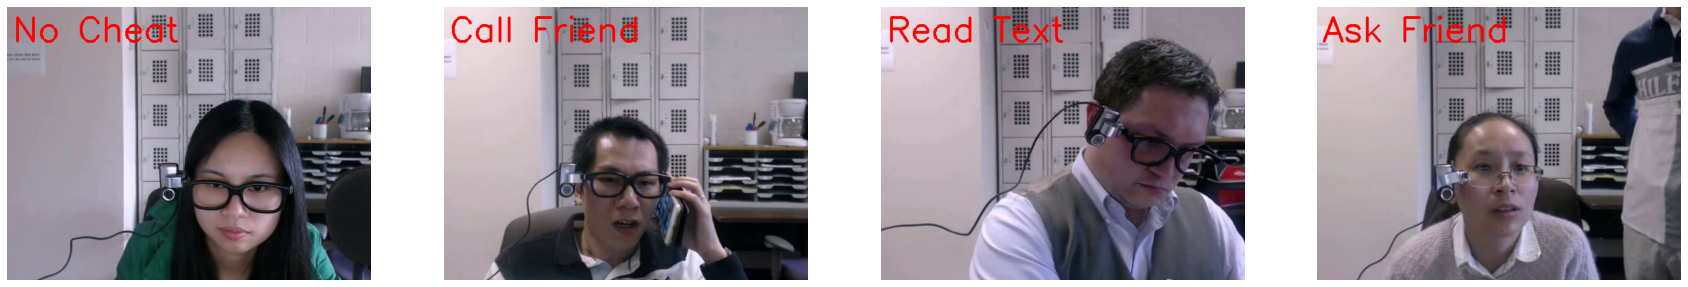

time: 6.92 s (started: 2022-04-21 08:47:29 +07:00)


In [5]:
def example_image():
  print('[INFO] Example Image of Each Class')
  plt.figure(figsize=(30, 30))

  all_classes_names = os.listdir(f'{BASE_DIR}/HAR_frame/all_subject/split_perdata_perclass/train/')
  random_range = random.sample(range(len(all_classes_names)), MODEL_OUTPUT_SIZE)

  for counter, random_index in enumerate(random_range, 1):
    selected_class_name = all_classes_names[random_index]
    video_files_names_list = os.listdir(f'{BASE_DIR}/HAR_frame/all_subject/split_perdata_perclass/train/{selected_class_name}')
    selected_video_file_name = random.choice(video_files_names_list)
    
    video_reader = cv2.VideoCapture(
      f'{BASE_DIR}/HAR_frame/all_subject/split_perdata_perclass/train/{selected_class_name}/{selected_video_file_name}')
    _, bgr_frame = video_reader.read()
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    
    selected_class_dict = CLASSES_DICT[int(selected_class_name)]
    
    cv2.putText(rgb_frame, selected_class_dict, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 4)
    plt.subplot(1, MODEL_OUTPUT_SIZE, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')
    plt.savefig(f'{BASE_DIR}/HAR_data/all_subject/plot/plot_example_class.png')
    
example_image()

### Data Augmentation

In [6]:
train_datagen = ImageDataGenerator(
  rotation_range=10,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=[0.9,1.0],
  fill_mode='nearest',
  horizontal_flip=True,
  vertical_flip=True,
  rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

time: 0 ns (started: 2022-04-21 08:47:36 +07:00)


### Function Construct Model

In [7]:
def get_model_name(fold_var):
  return f'{BASE_DIR}/HAR_data/all_subject/checkpoint/HAR_MobileNetV2_Model_fold-{str(fold_var)}.h5'

time: 0 ns (started: 2022-04-21 08:47:38 +07:00)


In [8]:
def get_model(fold_var):
  print(f'\n[INFO] Construct Model Fold-{str(fold_var)}')
  baseModel = MobileNetV2(weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
    classes=MODEL_OUTPUT_SIZE)
  baseModel.trainable = False
  
  if fold_var == 1:
    with open(f'{BASE_DIR}/HAR_data/all_subject/report/HAR_model_summary_base.txt', 'w') as f:
      baseModel.summary(print_fn=lambda x: f.write(x + '\n'))
  
  headModel = baseModel.output
  headModel = Conv2D(100, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))(headModel)
  headModel = MaxPooling2D(pool_size=(2, 2))(headModel)
  headModel = Flatten(name='flatten')(headModel)
  headModel = Dense(2048, activation='relu')(headModel)
  headModel = Dense(2048, activation='relu')(headModel)
  headModel = Dense(1024, activation='relu')(headModel)
  headModel = Dense(1024, activation='relu')(headModel)
  headModel = Dense(512, activation='relu')(headModel)
  headModel = Dense(MODEL_OUTPUT_SIZE, activation='softmax')(headModel)
  
  model = Model(inputs=baseModel.input, outputs=headModel)
  for layer in baseModel.layers:
    layer.trainable = False
  
  opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  
  if fold_var == 1:
    with open(f'{BASE_DIR}/HAR_data/all_subject/report/HAR_model_summary.txt', 'w') as f:
      model.summary(print_fn=lambda x: f.write(x + '\n'))

  return model

time: 0 ns (started: 2022-04-21 08:47:39 +07:00)


### Function Plot History

In [9]:
def plot_history(H, fold_var):
  print(f'\n[INFO] Plot History Fold-{str(fold_var)}')
  plt.style.use('ggplot')
  plt.figure()
  plt.plot(range(1, len(H.history['loss'])+1), H.history['loss'], label='train_loss')
  plt.plot(range(1, len(H.history['val_loss'])+1), H.history['val_loss'], label='val_loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Value')
  plt.legend(loc='best', bbox_to_anchor=(1.25, 1))
  plt.savefig(f'{BASE_DIR}/HAR_data/all_subject/plot/plot_loss_fold-{str(fold_var)}.png')

  plt.style.use('ggplot')
  plt.figure()
  plt.plot(range(1, len(H.history['accuracy'])+1), H.history['accuracy'], label='train_acc')
  plt.plot(range(1, len(H.history['val_accuracy'])+1), H.history['val_accuracy'], label='val_acc')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Value')
  plt.legend(loc='best', bbox_to_anchor=(1.25, 1))
  plt.savefig(f'{BASE_DIR}/HAR_data/all_subject/plot/plot_accuracy_fold-{str(fold_var)}.png')
  
  report_df = pd.DataFrame({
      'loss': H.history['loss'],
      'val_loss': H.history['val_loss'],
      'accuracy': H.history['accuracy'],
      'val_accuracy': H.history['val_accuracy']
  })
  report_df.to_csv(f'{BASE_DIR}/HAR_data/all_subject/report/HAR_accuracy_loss_report_fold-{str(fold_var)}.csv')
  report_df.to_excel(f'{BASE_DIR}/HAR_data/all_subject/report/HAR_accuracy_loss_report_fold-{str(fold_var)}.xlsx')

time: 0 ns (started: 2022-04-21 08:47:40 +07:00)


### Function Evaluate Model

In [10]:
def evaluate_model(model, fold_var, train_data_generator, valid_data_generator, test_data_generator):
  print(f'\n[INFO] Evaluate Model Fold-{str(fold_var)}')

  train_score = model.evaluate_generator(train_data_generator, BATCH_SIZE)
  print(f'Train Accuracy: {train_score[1] * 100:.2f}%')
  print(f'Train Loss: {train_score[0] * 100:.2f}%\n')
  valid_score = model.evaluate_generator(valid_data_generator, BATCH_SIZE)
  print(f'Valid Accuracy: {valid_score[1] * 100:.2f}%')
  print(f'Valid Loss: {valid_score[0] * 100:.2f}%\n')
  test_score = model.evaluate_generator(test_data_generator, BATCH_SIZE)
  print(f'Test Accuracy: {test_score[1] * 100:.2f}%')
  print(f'Test Loss: {test_score[0] * 100:.2f}%\n')
  
  file = open(f'{BASE_DIR}/HAR_data/all_subject/report/HAR_model_evaluate_fold-{str(fold_var)}.txt', 'w')
  file.write(
    f'[INFO] Evaluate Model Fold-{str(fold_var)}\nTrain Accuracy: {train_score[1] * 100:.2f}%\nTrain Loss: {train_score[0] * 100: .2f} %\nValid Accuracy: {valid_score[1] * 100:.2f}%\nValid Loss: {valid_score[0] * 100:.2f}%\nTest Accuracy: {test_score[1] * 100:.2f}%\nTest Loss: {test_score[0] * 100:.2f}%\n')
  file.close()

time: 0 ns (started: 2022-04-21 08:47:41 +07:00)


### Function Confusion Matrix

In [11]:
def plot_confusion_matrix(cm, classes, fold_var, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
  print(f'\n[INFO] Confusion Matrix, Without Normalization Fold-{str(fold_var)}')
  plt.figure(figsize=(10, 10))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    print('Normalized Confusion Matrix')
  else:
    print('Confusion Matrix, Without Normalization')

  thresh = cm.max()/2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.savefig(f'{BASE_DIR}/HAR_data/all_subject/plot/plot_confusion_matrix_fold-{str(fold_var)}.png')

time: 16 ms (started: 2022-04-21 08:47:41 +07:00)


In [12]:
def plot_confusion_matrix_normalized(cm, classes, fold_var, normalize=True, title='Confusion Matrix', cmap=plt.cm.Blues):
  print(f'\n[INFO] Normalized Confusion Matrix Fold-{str(fold_var)}')
  plt.figure(figsize=(10, 10))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    print('Normalized Confusion Matrix')
  else:
    print('Confusion Matrix, Without Normalization')

  thresh = cm.max()/2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.savefig(f'{BASE_DIR}/HAR_data/all_subject/plot/plot_confusion_matrix_normalized_fold-{str(fold_var)}.png')

time: 16 ms (started: 2022-04-21 08:47:42 +07:00)


### Training, Save, & Evaluate Model

In [13]:
train_data = pd.read_csv(f'{BASE_DIR}/HAR_frame/all_subject/split_perdata/train_labels.csv')
test_data = pd.read_csv(f'{BASE_DIR}/HAR_frame/all_subject/split_perdata/test_labels.csv')

train_y = train_data.label
train_x = train_data.drop(['label'], axis=1)

skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=42)
data_kfold = pd.DataFrame()

validation_accuracy = []
validation_loss = []
fold_var = 1

time: 172 ms (started: 2022-04-21 08:47:43 +07:00)



======[INFO] Fold-1======
Found 7200 validated image filenames belonging to 4 classes.
Found 1800 validated image filenames belonging to 4 classes.

[INFO] Construct Model Fold-1
Epoch 1/20
450/450 [==============================] - ETA: 0s - loss: 0.2914 - accuracy: 0.8867
Epoch 1: val_accuracy improved from -inf to 0.95145, saving model to ../HAR_data/all_subject/checkpoint\HAR_MobileNetV2_Model_fold-1.h5
450/450 [==============================] - 1411s 3s/step - loss: 0.2914 - accuracy: 0.8867 - val_loss: 0.1488 - val_accuracy: 0.9515
Epoch 2/20
450/450 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.9604
Epoch 2: val_accuracy improved from 0.95145 to 0.97824, saving model to ../HAR_data/all_subject/checkpoint\HAR_MobileNetV2_Model_fold-1.h5
450/450 [==============================] - 1039s 2s/step - loss: 0.1123 - accuracy: 0.9604 - val_loss: 0.0793 - val_accuracy: 0.9782
Epoch 3/20
450/450 [==============================] - ETA: 0s - loss: 0.0839 - accuracy

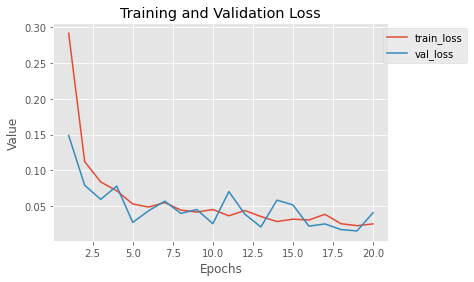

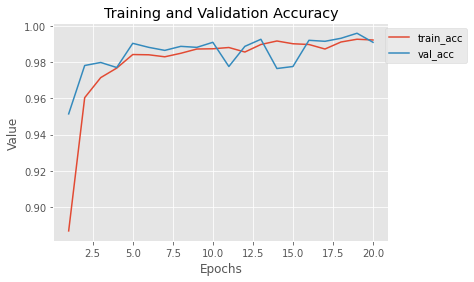

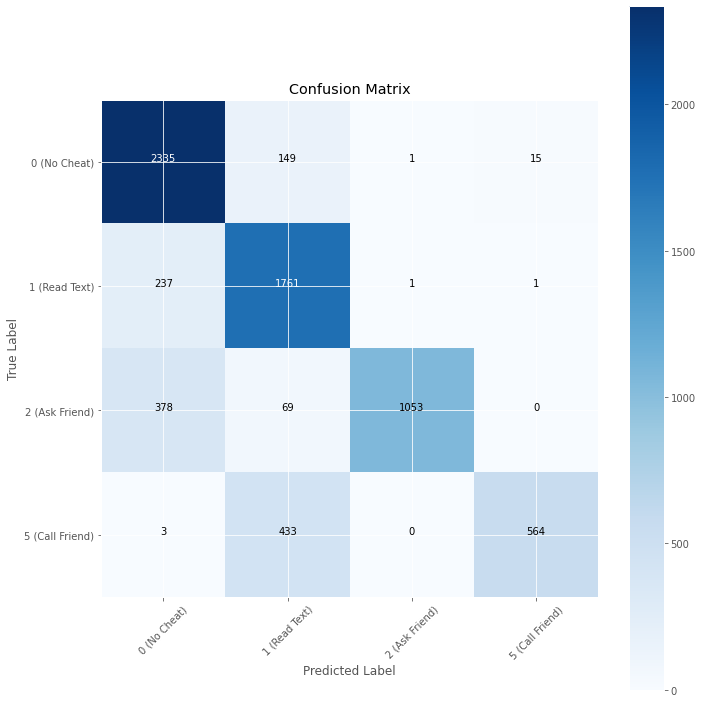

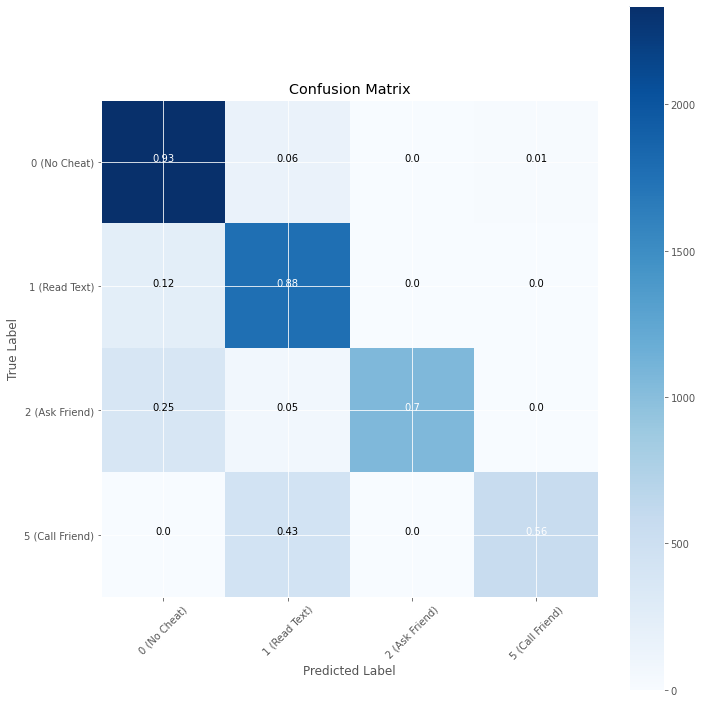

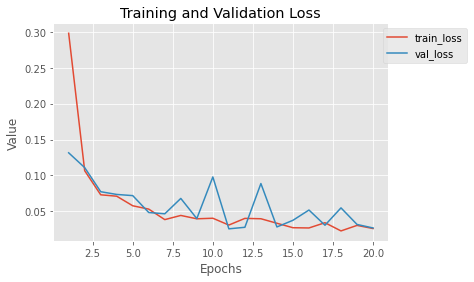

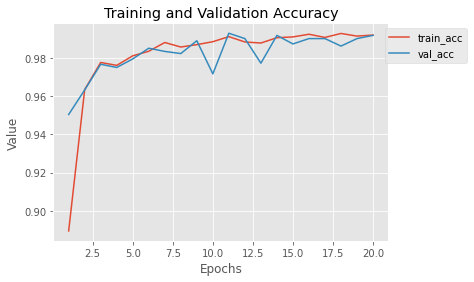

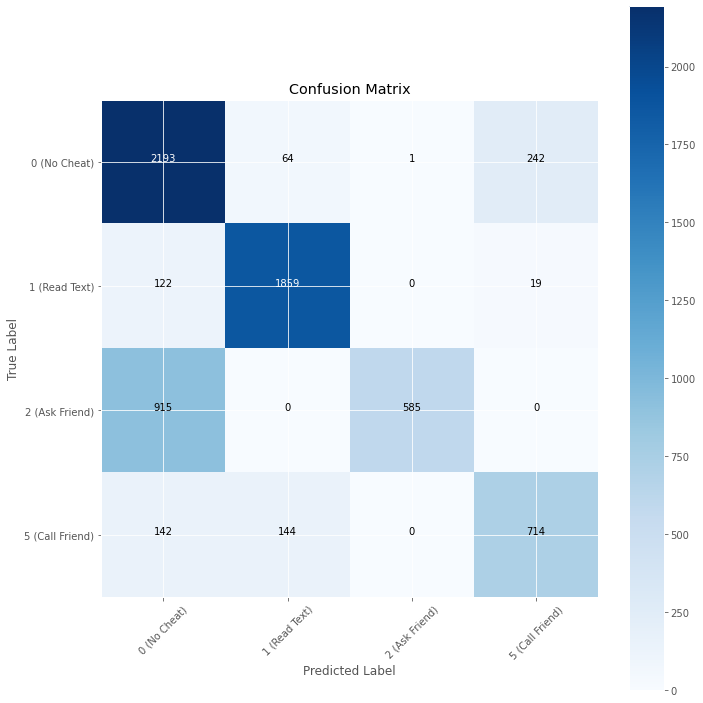

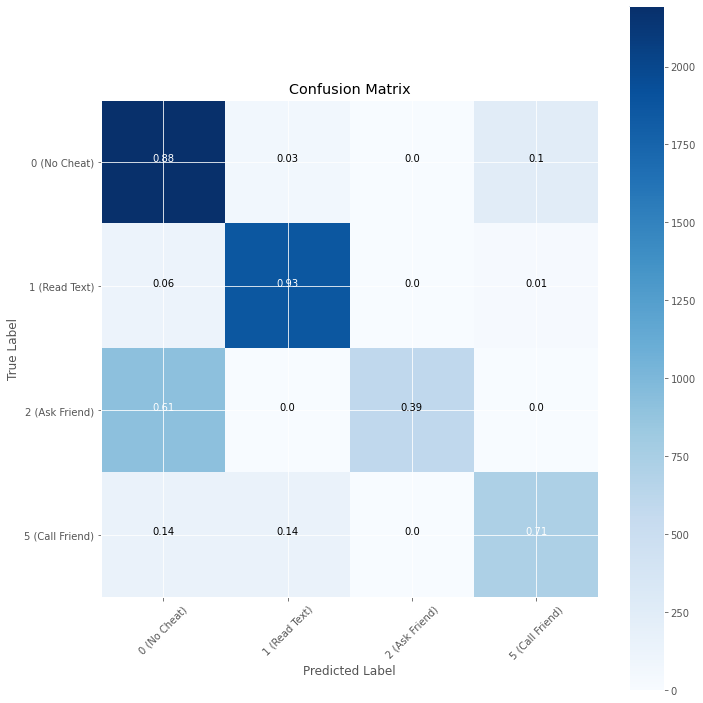

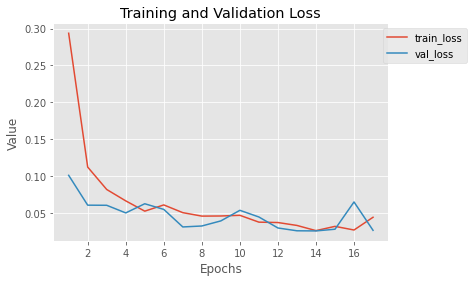

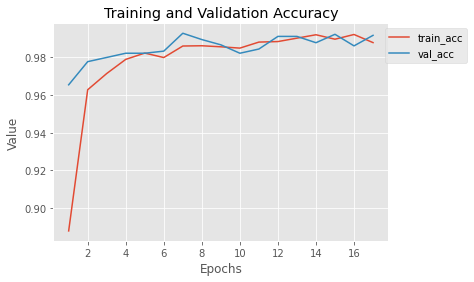

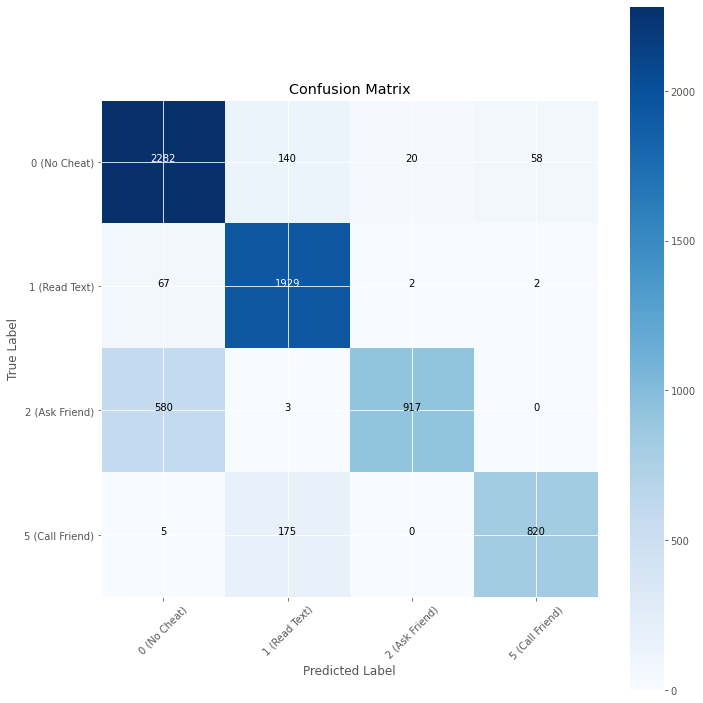

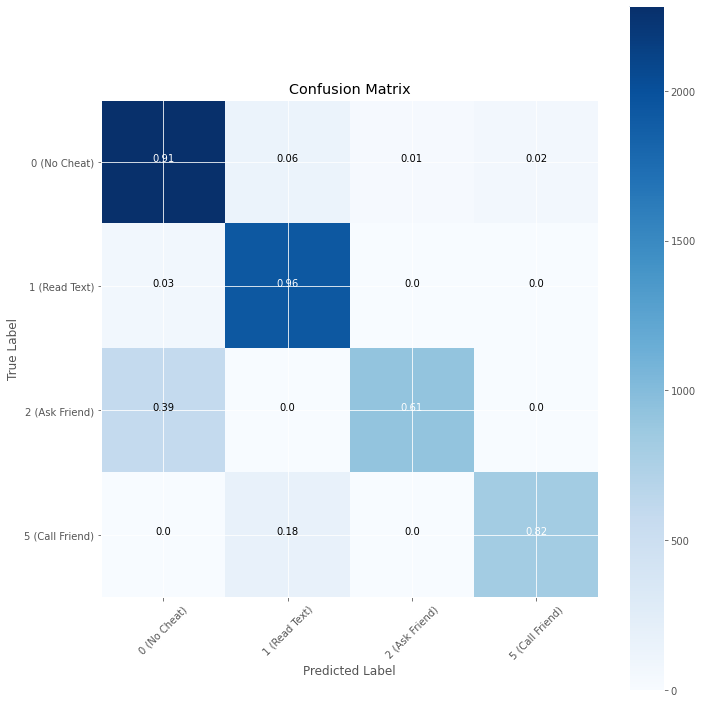

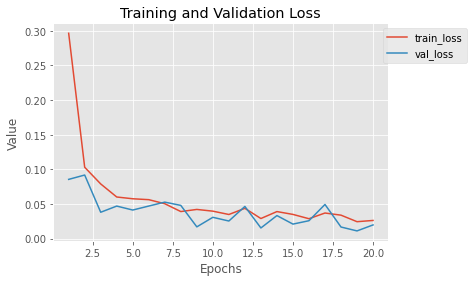

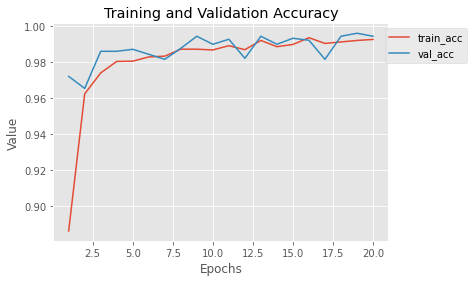

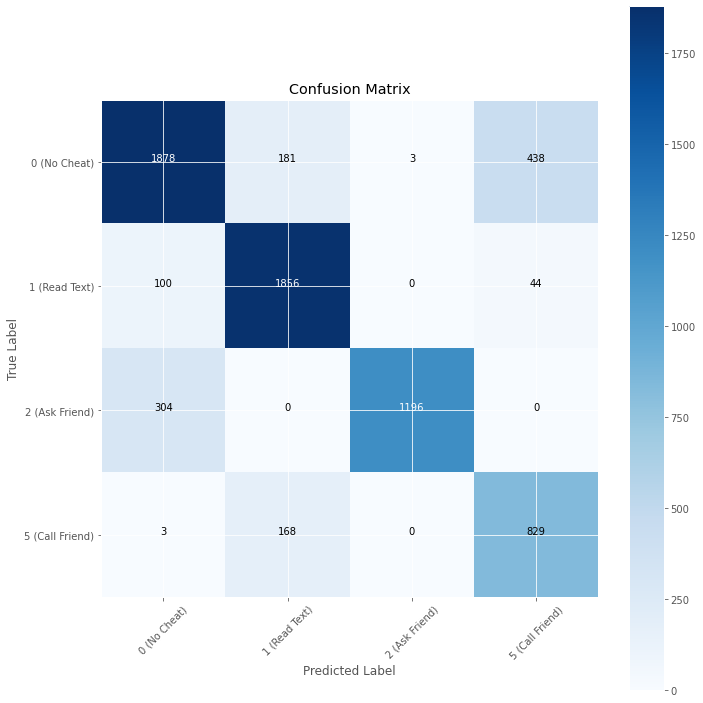

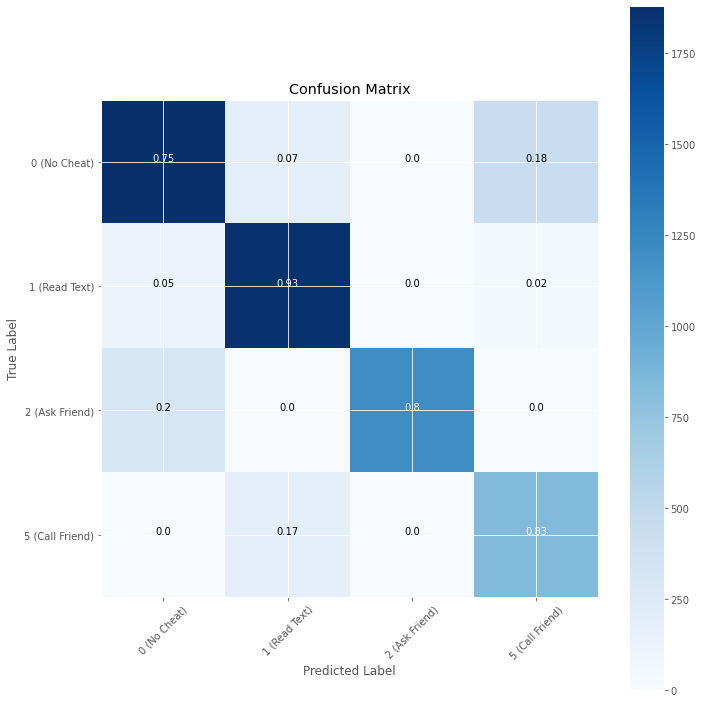

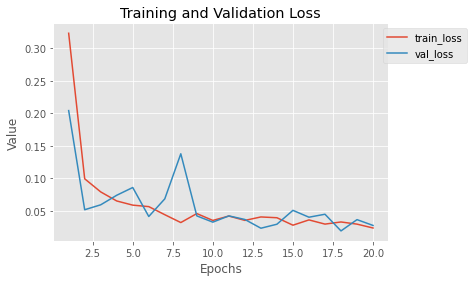

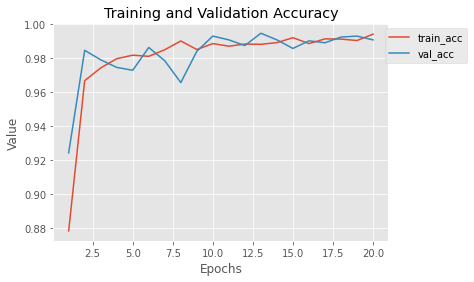

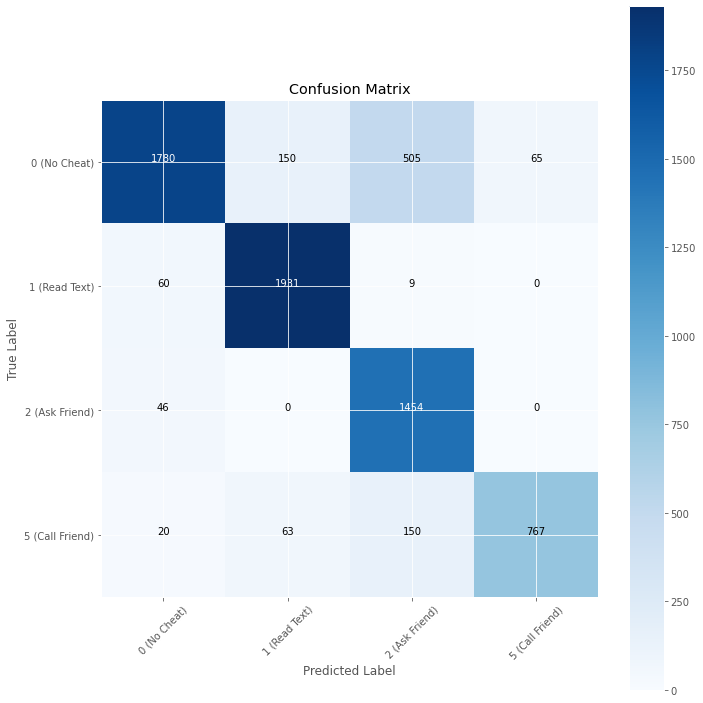

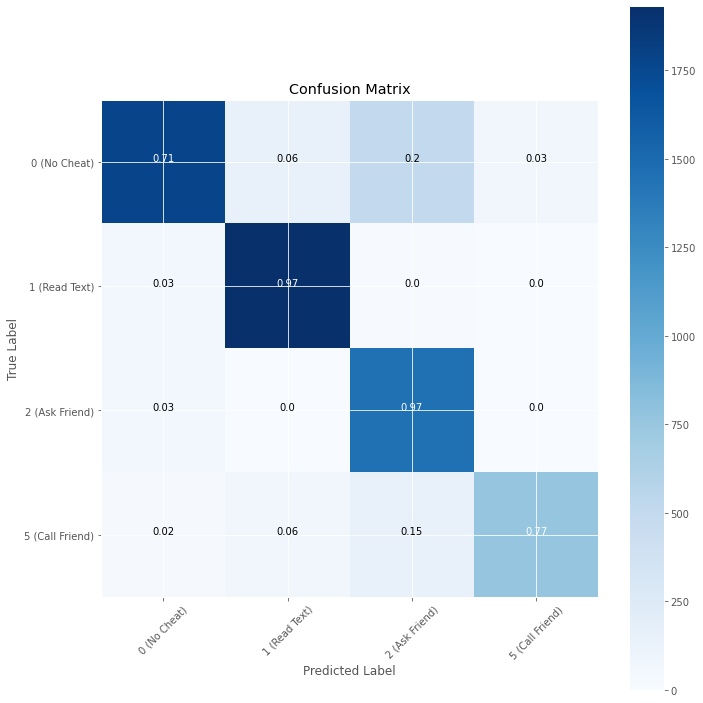

time: 1d 1h 34min 12s (started: 2022-04-21 08:47:45 +07:00)


In [14]:
for train_index, val_index in list(skf.split(train_x, train_y)):
  print(f'\n======[INFO] Fold-{str(fold_var)}======')
  
  training_data = train_data.iloc[train_index]
  validation_data = train_data.iloc[val_index]
  
  train_data_generator = train_datagen.flow_from_dataframe(
    training_data, 
    directory=f'{BASE_DIR}/HAR_frame/all_subject/split_perdata/train/',
    x_col="filename",
    y_col="label",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True)
  valid_data_generator = train_datagen.flow_from_dataframe(
    validation_data,
    directory=f'{BASE_DIR}/HAR_frame/all_subject/split_perdata/train/',
    x_col="filename",
    y_col="label",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True)
  
  model = get_model(fold_var)
  checkpoint = tf.keras.callbacks.ModelCheckpoint(
      get_model_name(fold_var),
      monitor='val_accuracy',
      verbose=1,
      save_best_only=True,
      mode='max')
  early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_accuracy',
      patience=10,
      verbose=1,
      mode='auto',
      baseline=None)
  history = model.fit(train_data_generator,
    steps_per_epoch=train_data_generator.samples // train_data_generator.batch_size,
    epochs=EPOCHS,
    validation_data=valid_data_generator,
    validation_steps=valid_data_generator.samples // valid_data_generator.batch_size,
    verbose=1,
    callbacks=[checkpoint, early_stopping])
  
  model.save(f'{BASE_DIR}/HAR_data/all_subject/checkpoint/HAR_MobileNetV2_Model_No_Optimizer_fold-{str(fold_var)}.h5', include_optimizer=False)
  
  plot_history(history, fold_var)
  
  model.load_weights(f'{BASE_DIR}/HAR_data/all_subject/checkpoint/HAR_MobileNetV2_Model_fold-{str(fold_var)}.h5')
  results = model.evaluate(valid_data_generator)
  results = dict(zip(model.metrics_names, results))
  validation_accuracy.append(results['accuracy'])
  validation_loss.append(results['loss'])
  print(f'\n[INFO] Validation Accuracy Fold-{str(fold_var)}: {validation_accuracy}')
  print(f'\n[INFO] Validation Loss Fold-{str(fold_var)}: {validation_loss}')
  with open(f'{BASE_DIR}/HAR_data/all_subject/report/HAR_validation_fold-{str(fold_var)}.csv', 'w') as f:
    for item in validation_accuracy:
      f.write(f'[INFO] Validation Accuracy Fold-{str(fold_var)}: {item}\n')
    for item in validation_loss:
      f.write(f'[INFO] Validation Loss Fold-{str(fold_var)}: {item}\n')
  
  test_data_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory=f'{BASE_DIR}/HAR_frame/all_subject/split_perdata/test/',
    x_col="filename",
    y_col="label",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False)
  
  evaluate_model(model, fold_var, train_data_generator, valid_data_generator, test_data_generator)

  test_data_generator.reset()
  test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)
  predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)
  predicted_classes = np.argmax(predictions, axis=1)
  true_classes = test_data_generator.classes
  class_labels = list(test_data_generator.class_indices.keys())
  
  print(f'\n[INFO] Metrics Score Fold-{str(fold_var)}')
  accuracy = accuracy_score(true_classes, predicted_classes)
  precision = precision_score(true_classes, predicted_classes, pos_label='positive', average='macro')
  recall = recall_score(true_classes, predicted_classes, pos_label='positive', average='macro')
  f1 = f1_score(true_classes, predicted_classes, pos_label='positive', average='macro')
  print(f'Accuracy: {accuracy}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1 Score: {f1}')
  file = open(f'{BASE_DIR}/HAR_data/all_subject/report/HAR_metrics_fold-{str(fold_var)}.txt', 'w')
  file.write(
    f'[INFO] Metrics Score Fold-{str(fold_var)}\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n')
  file.close()
  
  print(f'\n[INFO] Classification Report Fold-{str(fold_var)}')
  reportShow = classification_report(true_classes, predicted_classes, target_names=class_labels)
  print(reportShow)
  report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
  report_df = pd.DataFrame(report).transpose()
  report_df.to_csv(f'{BASE_DIR}/HAR_data/all_subject/report/HAR_classification_report_fold-{str(fold_var)}.csv')
  report_df.to_excel(f'{BASE_DIR}/HAR_data/all_subject/report/HAR_classification_report_fold-{str(fold_var)}.xlsx')
  
  cm = confusion_matrix(true_classes, predicted_classes)
  plot_confusion_matrix(cm, class_labels, fold_var)
  plot_confusion_matrix_normalized(cm, class_labels, fold_var)
  
  data_kfold[fold_var] = predicted_classes
  data_kfold.to_csv(f'{BASE_DIR}/HAR_data/all_subject/report/HAR_data_kfold_fold-{str(fold_var)}.csv')
  data_kfold.to_excel(f'{BASE_DIR}/HAR_data/all_subject/report/HAR_data_kfold_fold-{str(fold_var)}.xlsx')
  tf.keras.backend.clear_session()
  fold_var += 1

### Prediction (Input Image)

In [5]:
BASE_DIR_BEST = './model_best'
base_dir_new = './model_new'

time: 16 ms (started: 2022-06-21 10:11:16 +07:00)


[INFO] Prediction (Image)
Prediksi Kelas dan Probabilitas-nya pada Foto
Call Friend: 99.06% (Terbesar)
Read Text: 0.41%
No Cheat: 0.31%
Ask Friend: 0.22%


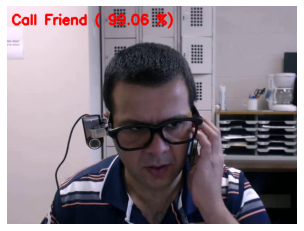

time: 15.8 s (started: 2022-06-21 10:11:33 +07:00)


In [6]:
model = load_model(
    f'{BASE_DIR_BEST}/checkpoint/HAR_MobileNetV2_Model_Best.h5')

def load_image(filename):
  img = load_img(filename, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
  img = img_to_array(img)
  img = img.reshape(1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)
  img = img.astype('float32')
  img = img / 255.0
  return img

def run_prediction():
  print('[INFO] Prediction (Image)')
  print('Prediksi Kelas dan Probabilitas-nya pada Foto')
  location_image = f'{base_dir_new}/media/image/5 (Call Friend)_Test (1).jpg'
  img = load_image(location_image)
  
  prediction = model.predict(img)
  prediction = prediction[0]
  
  sort_index = np.argsort(prediction)[::-1]
  for i in sort_index:
    if i == sort_index[0]:
      print(f'{CLASSES_LIST[i]}: {prediction[i] * 100:.2f}% (Terbesar)')
    else:
      print(f'{CLASSES_LIST[i]}: {prediction[i] * 100:.2f}%')
  
  max_index = np.argmax(prediction)
  prediction_percentage = prediction[max_index] * 100
  class_list = CLASSES_LIST[max_index]
  
  plot_image = mpimg.imread(location_image)
  cv2.putText(plot_image, f'{class_list} ({prediction_percentage: .2f} %)', (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 4)
  plt.imshow(plot_image)
  plt.axis('off')
  # plt.savefig(f'{BASE_DIR}/HAR_data/all_subject/plot/plot_prediction_image.png')

run_prediction()

### Prediction (Input Video)

In [7]:
def predict_on_live_video(video_file_path, output_file_path):
  print('[INFO] Prediction (Video)')
  predicted_labels_probabilities_deque = deque(maxlen=FPS)
  video_reader = cv2.VideoCapture(video_file_path)
  original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
  video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc(
      'M', 'P', '4', 'V'), FPS, (original_video_width, original_video_height))

  while True:
    status, frame = video_reader.read()

    if not status:
      break

    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    normalized_frame = resized_frame / 255
    predicted_labels_probabilities = model.predict(
        np.expand_dims(normalized_frame, axis=0))[0]
    predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

    if len(predicted_labels_probabilities_deque) == FPS:
      predicted_labels_probabilities_np = np.array(
          predicted_labels_probabilities_deque)
      predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(
          axis=0)
      
      # predicted_label = np.argmax(predicted_labels_probabilities_averaged)
      # predicted_class_name = CLASSES_LIST[predicted_label]
      # cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
      
      predicted_labels_probabilities_averaged_sorted_indexes = np.argsort(
          predicted_labels_probabilities_averaged)[::-1]

      for predicted_label in predicted_labels_probabilities_averaged_sorted_indexes:
        predicted_class_name = CLASSES_LIST[predicted_label]
        predicted_probability = predicted_labels_probabilities_averaged[predicted_label] * 100
        if predicted_label == predicted_labels_probabilities_averaged_sorted_indexes[0]:
          cv2.putText(frame, 'Prediksi Kelas:', (10, 30),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 69, 255), 2)
          cv2.putText(frame, f'{predicted_class_name} ({predicted_probability:.2f}%)',
                      (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
        elif predicted_label == predicted_labels_probabilities_averaged_sorted_indexes[1]:
          cv2.putText(frame, f'{predicted_class_name} ({predicted_probability:.2f}%)',
                      (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 69, 255), 2)
        elif predicted_label == predicted_labels_probabilities_averaged_sorted_indexes[2]:
          cv2.putText(frame, f'{predicted_class_name} ({predicted_probability:.2f}%)',
                      (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 69, 255), 2)
        elif predicted_label == predicted_labels_probabilities_averaged_sorted_indexes[3]:
          cv2.putText(frame, f'{predicted_class_name} ({predicted_probability:.2f}%)',
                      (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 69, 255), 2)

      video_writer.write(frame)

  # video_reader.release()
  video_writer.release()

  predicted_labels_probabilities_np = np.zeros(
      (FPS, MODEL_OUTPUT_SIZE), dtype=np.float)
  video_reader = cv2.VideoCapture(video_file_path)
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window = video_frames_count // FPS

  for frame_counter in range(FPS):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES,
                     frame_counter * skip_frames_window)
    _, frame = video_reader.read()
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    normalized_frame = resized_frame / 255
    predicted_labels_probabilities = model.predict(
        np.expand_dims(normalized_frame, axis=0))[0]
    predicted_labels_probabilities_np[frame_counter] = predicted_labels_probabilities

  predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(
      axis=0)
  predicted_labels_probabilities_averaged_sorted_indexes = np.argsort(
      predicted_labels_probabilities_averaged)[::-1]

  print('Summary Prediksi Kelas dan Probabilitas-nya pada Video')
  for predicted_label in predicted_labels_probabilities_averaged_sorted_indexes:
    predicted_class_name = CLASSES_LIST[predicted_label]
    predicted_probability = predicted_labels_probabilities_averaged[predicted_label]
    print(
        f'{predicted_class_name} ({(predicted_probability*100):.2f}%)')

  video_reader.release()


output_directory = f'{BASE_DIR}/HAR_data/all_subject/video_prediction'
os.makedirs(output_directory, exist_ok=True)
video_title = 'Yousef1-30seconds'
input_video_file_path = f'{output_directory}/{video_title}.mp4'
output_video_file_path = f'{output_directory}/{video_title}-Output-WSize{FPS}.mp4'

predict_on_live_video(input_video_file_path, output_video_file_path)
VideoFileClip(output_video_file_path).ipython_display(
    width=700, autoplay=1, loop=1)


[INFO] Prediction (Video)
Summary Prediksi Kelas dan Probabilitas-nya pada Video
Read Text (78.98%)
No Cheat (12.85%)
Ask Friend (8.02%)
Call Friend (0.15%)
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


time: 3min 4s (started: 2022-06-21 10:12:00 +07:00)
